In [1]:
from qiskit import QuantumCircuit, Aer
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager
from qiskit_ibm_provider import IBMProvider
from qiskit.visualization import plot_histogram
import numpy as np

In [2]:
provider = IBMProvider()
backend = provider.get_backend("ibmq_jakarta")

# Analysing backend

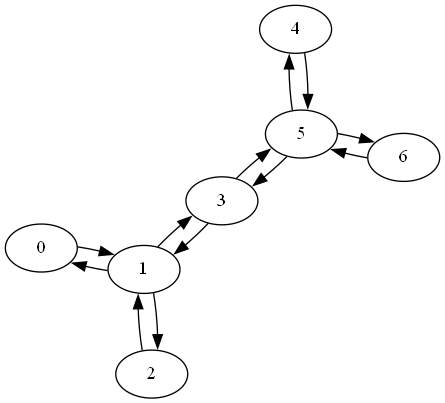

In [3]:
backend.coupling_map.draw()

In [4]:
backend.operations

[Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
 Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='x', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]),
 Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]),
 Delay(duration=t[unit=dt]),
 qiskit.circuit.controlflow.if_else.IfElseOp]

# Generate random 2 qubits circuit with n operations

We will use qubits 3, 5 for the circuit and try to detect the CNOT with 1, 4, 6.
For now we only do CNOTs with 3 as the control.

In [5]:
n = 20
q1 = 3
q2 = 5

snoopers = [1, 4, 6]

In [7]:
def create_random_qc():
    qc = QuantumCircuit(backend.num_qubits, 3)
    qc.h(snoopers)
    qc.barrier()
    # ops = cx 1, rz 1, rz 2, sx 1 sx 2, x 1, x 2
    for i in range(n):
        op_type = np.random.randint(0, 7)
        match op_type:
            case 0:
                qc.cx(q1, q2)
            case 1:
                qc.rz(np.random.random()*(2*np.pi), q1)
            case 2:
                qc.rz(np.random.random()*(2*np.pi), q2)
            case 3:
                qc.sx(q1)
            case 4:
                qc.sx(q2)
            case 5:
                qc.x(q1)
            case 6:
                qc.x(q2)
    qc.barrier()
    qc.h(snoopers)
    for s_i, s in enumerate(snoopers):
        qc.measure(s, s_i)
    return qc

In [8]:
pm = generate_preset_pass_manager(0, backend)

tqcs = []
for i in range(300):
    tqcs.append(pm.run(create_random_qc()))

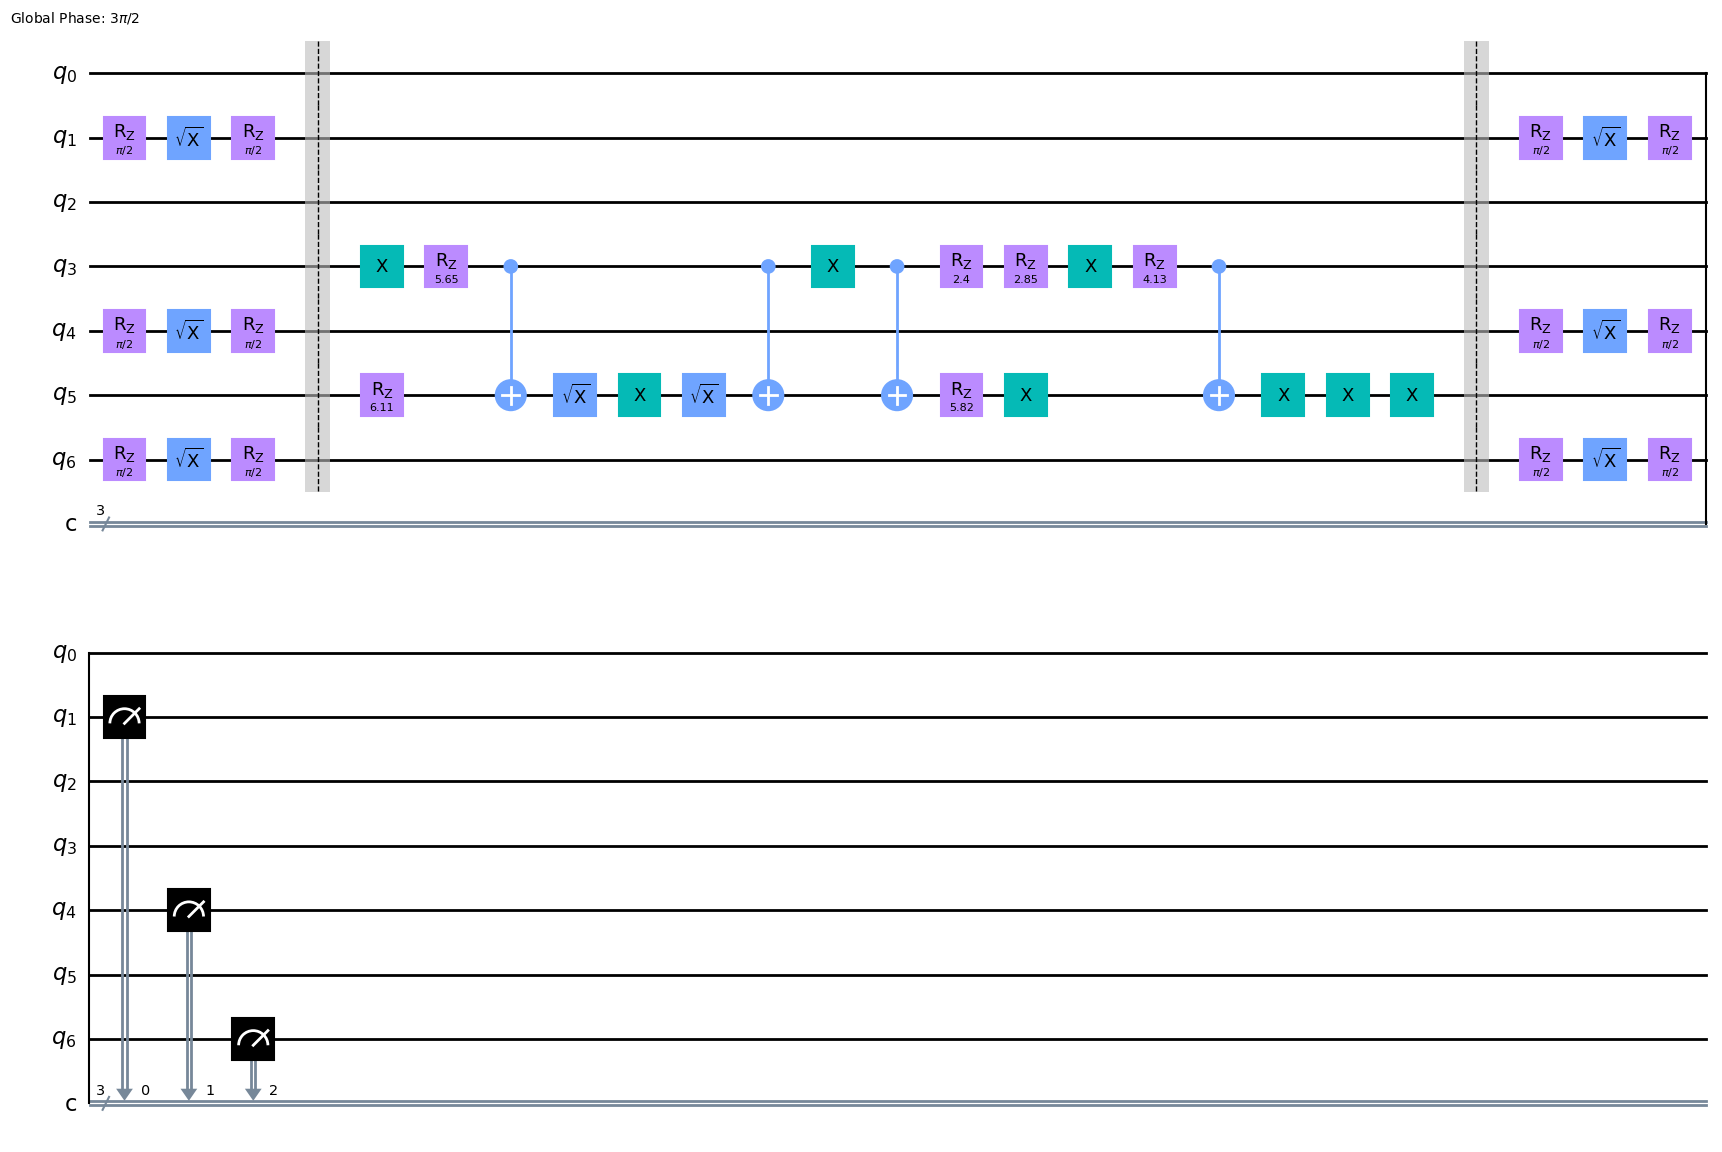

In [38]:
tqcs[1].draw('mpl')

In [9]:
# job = backend.run(tqcs, shots=8192)
job = job = provider.backend.retrieve_job('cg34bvc091pnm8dapl30')

In [10]:
job.job_id()

'cg34bvc091pnm8dapl30'

# Check

In [11]:
tqcs = job.circuits()

In [12]:
tqcs_by_cnot_count = {}

for qc_index, qc in enumerate(tqcs):
    cnots = qc.count_ops().get('cx', 0)
    tqcs_by_cnot_count.setdefault(cnots, [])
    tqcs_by_cnot_count[cnots].append(qc_index)

In [13]:
for count, indices in tqcs_by_cnot_count.items():
    print(count, len(indices))

0 10
4 65
2 70
3 70
5 32
1 38
6 9
7 5
8 1


In [15]:
qc_res_counts = job.result().get_counts()

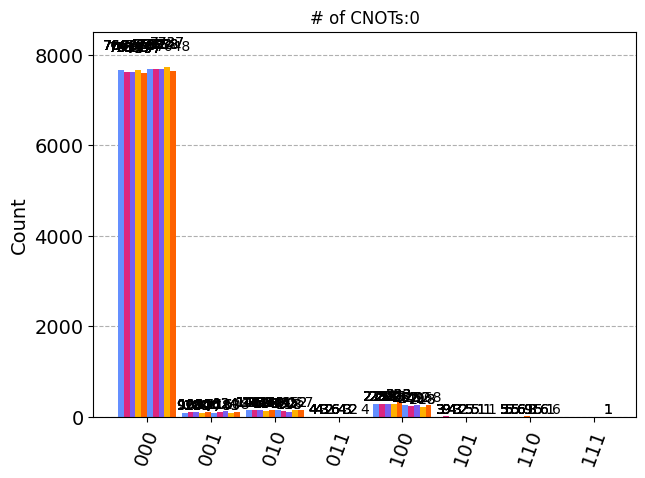

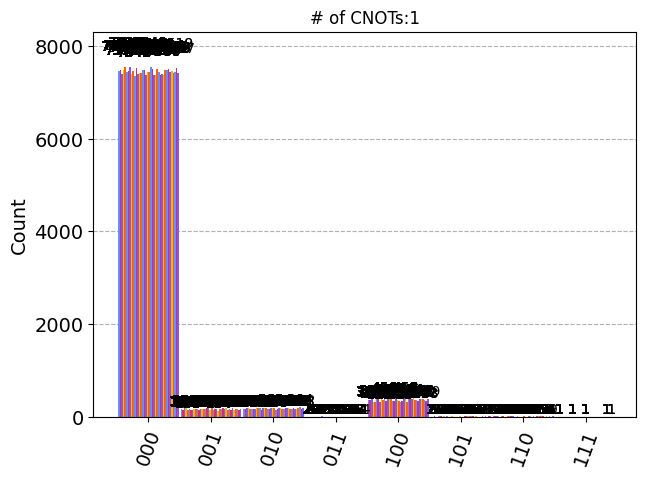

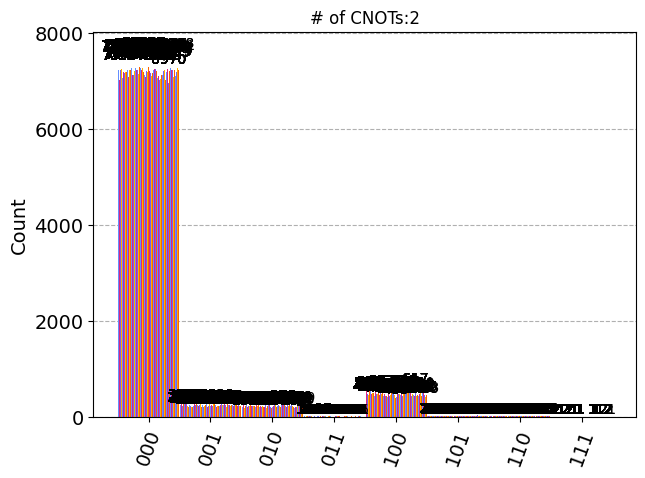

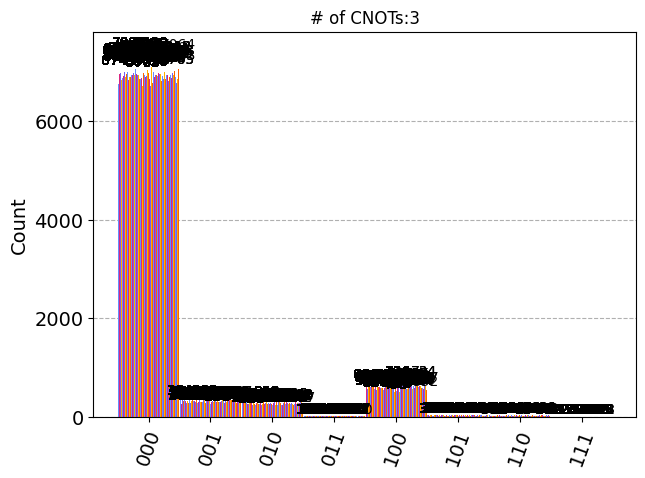

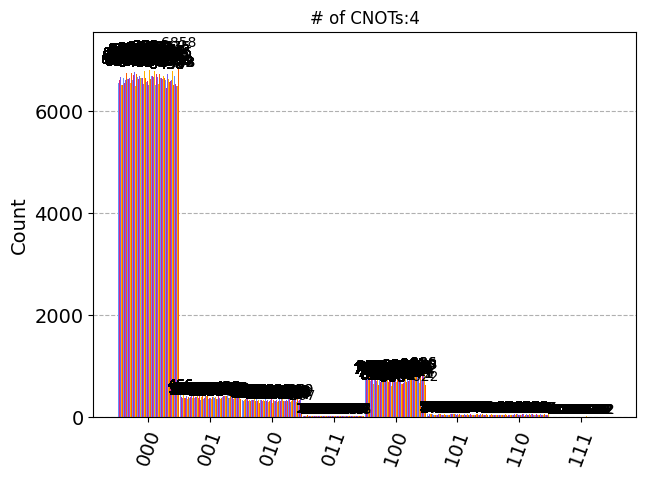

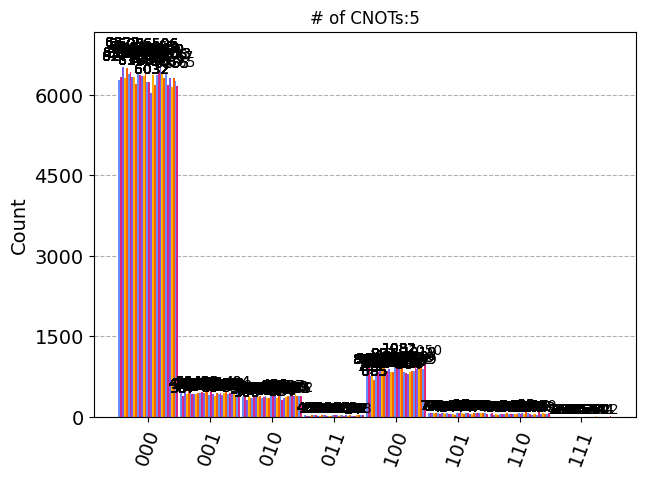

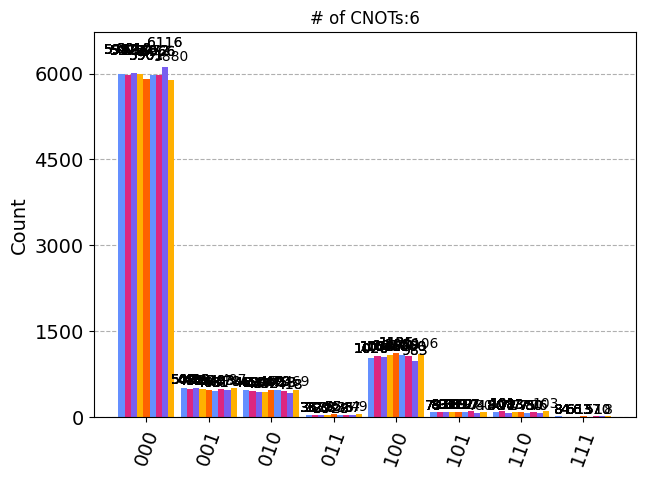

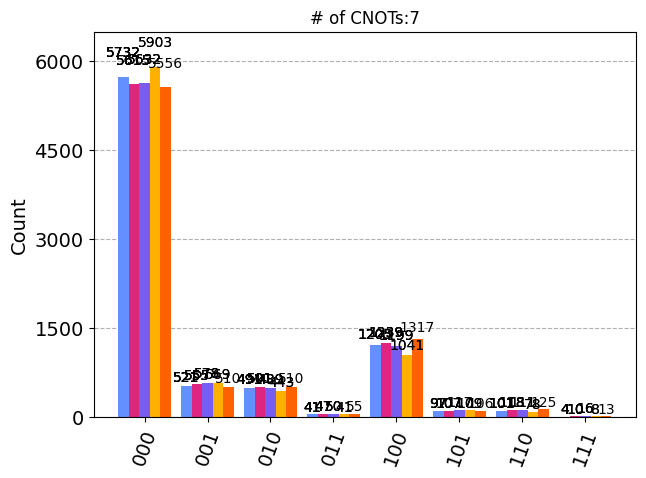

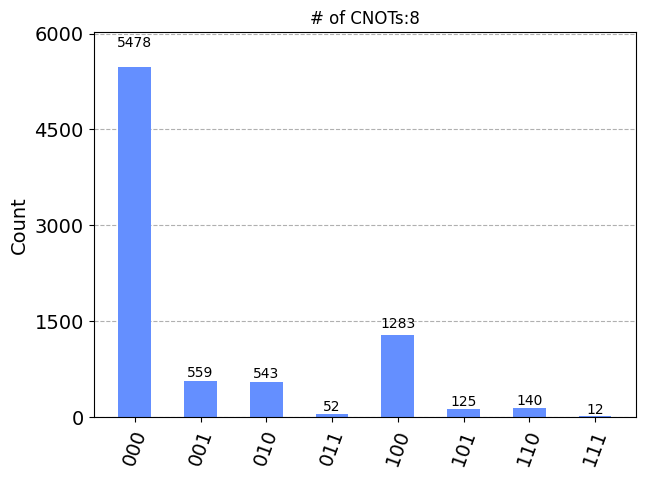

In [22]:
cnot_counts = sorted(tqcs_by_cnot_count.keys())
for cnot_count in cnot_counts:
    qc_indices = tqcs_by_cnot_count[cnot_count]
    data = []
    for qc_index in qc_indices:
        data.append(qc_res_counts[qc_index])
    display(plot_histogram(data, title='# of CNOTs:{}'.format(cnot_count)))

In [29]:
from scipy import stats

cnot_counts = sorted(tqcs_by_cnot_count.keys())
for cnot_count in cnot_counts:
    qc_indices = tqcs_by_cnot_count[cnot_count]
    data = []
    for qc_index in qc_indices:
        data.append(qc_res_counts[qc_index]['000'])
    print(cnot_count, len(qc_indices))
    display(stats.describe(data))
    print('=========')
    # display(plot_histogram(data, title='# of CNOTs:{}'.format(cnot_count)))

0 10


DescribeResult(nobs=10, minmax=(7597, 7737), mean=7665.8, variance=1519.0666666666668, skewness=0.0064549574301643545, kurtosis=-0.27505280304025304)

1 38


DescribeResult(nobs=38, minmax=(7342, 7549), mean=7447.526315789473, variance=2799.1209103840683, skewness=0.005955583627049907, kurtosis=-0.7567988380870649)

2 70


DescribeResult(nobs=70, minmax=(6970, 7303), mean=7189.242857142857, variance=6019.548861283644, skewness=-0.7357963794724003, kurtosis=-0.24622383344159227)

3 70


DescribeResult(nobs=70, minmax=(6709, 7099), mean=6916.171428571429, variance=6803.448447204967, skewness=-0.15885153689546122, kurtosis=0.1995181842201177)

4 65


DescribeResult(nobs=65, minmax=(6438, 6858), mean=6629.953846153846, variance=8639.638461538461, skewness=0.06859185399386983, kurtosis=-0.6052199875873079)

5 32


DescribeResult(nobs=32, minmax=(6032, 6522), mean=6328.21875, variance=12560.498991935483, skewness=-0.4774516364798418, kurtosis=0.06396372313764154)

6 9


DescribeResult(nobs=9, minmax=(5880, 6116), mean=5978.0, variance=4505.25, skewness=0.5543729557117744, kurtosis=0.4030058129008749)

7 5


DescribeResult(nobs=5, minmax=(5556, 5903), mean=5687.6, variance=18512.3, skewness=0.8042881807466913, kurtosis=-0.72594977295658)

8 1


C:\Users\thspr\AppData\Local\Temp\ipykernel_6844\3186339163.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  display(stats.describe(data))


DescribeResult(nobs=1, minmax=(5478, 5478), mean=5478.0, variance=nan, skewness=nan, kurtosis=nan)

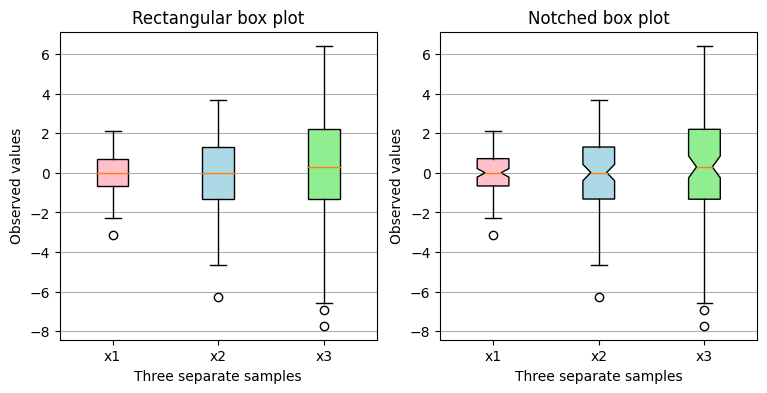

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Random test data
np.random.seed(19680801)
all_data = [np.random.normal(0, std, size=100) for std in range(1, 4)]
labels = ['x1', 'x2', 'x3']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# rectangular box plot
bplot1 = ax1.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Rectangular box plot')

# notch shape box plot
bplot2 = ax2.boxplot(all_data,
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_title('Notched box plot')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Three separate samples')
    ax.set_ylabel('Observed values')

plt.show()

In [ ]:
# cnot_count = qc.count_ops().get('cx', 0)
#     cnot_counts.append(cnot_count)

In [ ]:
# qc = QuantumCircuit(backend.num_qubits)

# ops = [qc.cx, qc.rz, qc.sx, qc.x]

# for i in range(n):
#     rand_op_index = np.random.randint(0, len(ops))
#     rand_op = ops[rand_op_index]
#     if rand_op_index != 0:
#         qubit_index = np.random.randint(0, 2)
#         # gates with angle
#         if rand_op_index == 1:
#             angle = np.random.random()*(2*np.pi)
#             rand_op(angle, qubit_index)
#         else:
#             rand_op(qubit_index)
#     else:
#         ctrl_qubit_index = np.random.randint(0, 2)
#         if ctrl_qubit_index == 0:
#             rand_op(0, 1)
#             # qc.cx(0, 1)
#         else:
#             rand_op(1, 0)
#             # qc.cx(1, 0)

